1.	What is inductive reasoning? Deductive reasoning? Give an example of each, different from the examples given in class.

Inductive reasoning applies a “bottom to top” approach to logic, while deductive reasoning applies a “top to bottom” approach. With deductive reasoning, if the premises of a statement are true, then the conclusion has to be true. But with the inductive form, even if the premises are true, that doesn’t mean the conclusion has to be true.

Inductive reasoning example: Person A is sick. Person B is sick. Person C is sick. Therefore, everyone is sick.

Dedective reasoning example: To get a Bachelor’s degree, a student must at least 120 credits. Karen has more than 120 credits. Therefore, Karen has a bachelor’s degree

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import skew
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as mse, confusion_matrix, classification_report, plot_confusion_matrix 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import  GridSearchCV,RandomizedSearchCV,train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df= pd.read_csv("abalone.csv")
df.head(5)

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [3]:
df.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


2.	Preprocess your dataset. Indicate which steps worked and which didn’t. Include your thoughts on why certain steps worked and certain steps didn’t.

Preprocessing steps that worked:
- Converting categorical values such as the sex values to numerical values with one-hot encoding
- Standarization after splitting the data
- Feature engineering by converting "ring" columns to "age" column
- Dectecting multicolinearity
- Removing extreme outliers

Preprocessing steps that did not worked:
- Handling missing data and cleaning up null values since the dataset does not have such values



In [4]:
# Null values
df.isnull().sum()

Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Shucked weight    0
Viscera weight    0
Shell weight      0
Rings             0
dtype: int64

In [5]:
# Check for the data types
# sex is nomial
df.dtypes

Sex                object
Length            float64
Diameter          float64
Height            float64
Whole weight      float64
Shucked weight    float64
Viscera weight    float64
Shell weight      float64
Rings               int64
dtype: object

From the attribute information, we can calculate the age by adding 1.5 to the rings. We can drop the Rings column since it has been used to calulate age.

In [6]:
#Feature engineering
df['age'] = df['Rings']+1.5
df = df.drop('Rings', axis = 1)
df.head(2)

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,age
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.15,16.5
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.07,8.5


In [7]:
#unique sex values
df["Sex"].unique()

array(['M', 'F', 'I'], dtype=object)

In [8]:
# Get one hot encoding of Sex
one_hot = pd.get_dummies(df['Sex'])
# Drop column Sex as it is now encoded
df = df.drop('Sex',axis = 1)
# concat orginal data with encoded values
df = pd.concat([df, one_hot], axis=1)
df.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,age,F,I,M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,16.5,0,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,8.5,0,0,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,10.5,1,0,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,11.5,0,0,1
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,8.5,0,1,0


- Outliers present in the dataset

<AxesSubplot:>

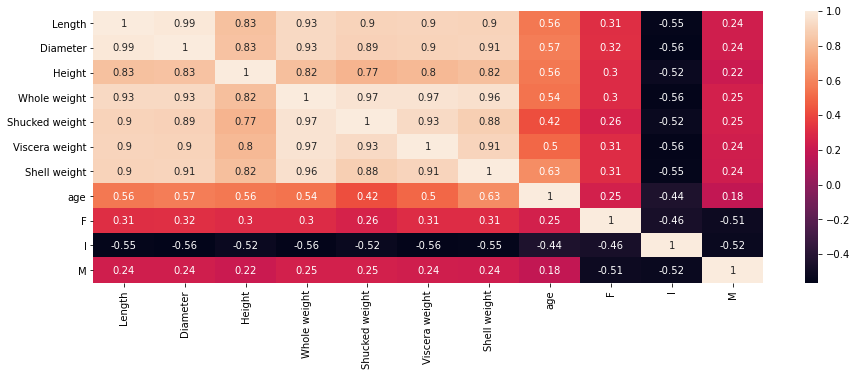

In [9]:
numerical_features = df.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(15,5))
sns.heatmap(df[numerical_features].corr(), annot=True)

Multicollinearity is the occurrence of high intercorrelations among two or more independent variables. The features Length and Diameter are highly correlated. We can use only Diameter from this set since it has the highest correlation with age.The whole weight, shucked weight, viscera weight, and shell weight are also highly correlated. But there is no multicolinearity with the target variable. We can remove Whole weight since it the sum of the other weights. We can 
drop sex 'F' and 'M' since the correlation is low.


#### Outlier handing for features

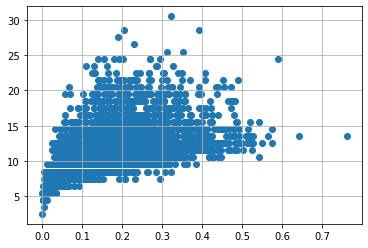

In [10]:
feature = 'Viscera weight'
plt.scatter(x = df[feature], y = df['age'])
plt.grid(True)

In [11]:
df.drop(df[(df['Viscera weight']> 0.5) & (df['age'] < 20)].index, inplace=True)
df.drop(df[(df['Viscera weight']<0.5) & (df['age'] > 25)].index, inplace=True)

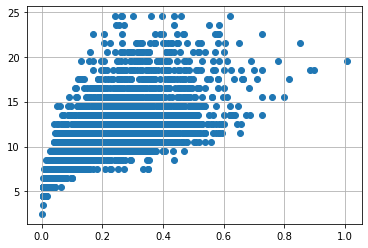

In [12]:
feature = 'Shell weight'
plt.scatter(x = df[feature], y = df['age'])
plt.grid(True)

In [13]:
df.drop(df[(df['Shell weight']> 0.6) & (df['age'] < 25)].index, inplace=True)
df.drop(df[(df['Shell weight']<0.8) & (df['age'] > 25)].index, inplace=True)

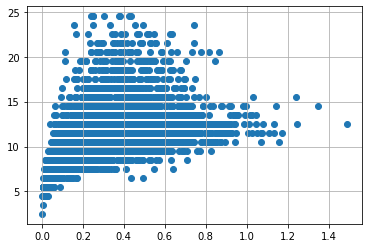

In [14]:
feature = 'Shucked weight'
plt.scatter(x = df[feature], y = df['age'],)
plt.grid(True)

In [15]:
df.drop(df[(df['Shucked weight']>= 1) & (df['age'] < 20)].index, inplace=True)
df.drop(df[(df['Shucked weight']<1) & (df['age'] > 20)].index, inplace=True)

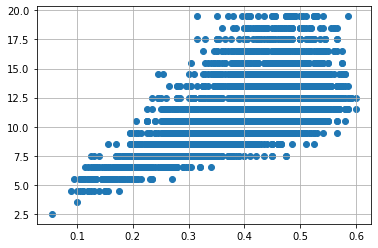

In [16]:
feature = 'Diameter'
plt.scatter(x = df[feature], y = df['age'],)
plt.grid(True)

In [17]:
df.drop(df[(df['Diameter']<0.1) & (df['age'] < 5)].index, inplace=True)
df.drop(df[(df['Diameter']<0.6) & (df['age'] > 25)].index, inplace=True)
df.drop(df[(df['Diameter']>=0.6) & (df['age']< 25)].index, inplace=True)

In [18]:
# Features
drop_cols = ['Length', 'Height', 'Whole weight', 'age', 'F', 'M']
X = df.drop(drop_cols, axis=1)
# Target
y = df ['age']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

sc= StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.fit_transform(X_test)

3. Create a decision tree model tuned to the best of your abilities. Explain how you tuned it.

In [19]:
dt = DecisionTreeRegressor(random_state=42)
dt = dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
rmse_dt = mse(y_test, y_pred,squared=False)
print("Decision Tree rsme before tuning :" ,rmse_dt)

Decision Tree rsme before tuning : 2.6820690853920373


In [20]:
parameters = {'max_depth': range(1, 20),   
    'min_samples_leaf': range(2,4),
    'min_samples_split': range(2,10),
    'random_state':[42]}
dt_gs = RandomizedSearchCV(dt, parameters,scoring='neg_root_mean_squared_error',n_jobs=-1,random_state=42)
dt_gs.fit(X_train, y_train)
print(dt_gs.best_params_)
print(dt_gs.best_score_)

{'random_state': 42, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_depth': 7}
-1.977171218223345


In [24]:
dt.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

Intially, I used all the parameters but the score was very high. I focused on max_depth, min_samples_leaf, and min_sample_split as these are the most common parameters. I adjusted the ranges for these parameters depending on rsme.

4.	Create a random forest model tuned to the best of your abilities. Explain how you tuned it.

In [22]:
rf = RandomForestRegressor(random_state=42)
rf = rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rmse_rf = mse(y_test, y_pred,squared=False)
print("Random Forest rsme before tuning :" ,rmse_rf)

Random Forest rsme before tuning : 2.0320342769629387


In [26]:
parameters = {
    'max_depth': range(1, 20),   
    'min_samples_leaf': range(2,4),
    'min_samples_split': range(2,10),
    'n_estimators': [100, 150, 200, 250],
    'random_state':[42]}
rf_gs = RandomizedSearchCV(rf, parameters,scoring='neg_root_mean_squared_error',n_jobs=-1,random_state=42)
rf_gs.fit(X_train, y_train)
print(rf_gs.best_params_)
print(rf_gs.best_score_)

{'random_state': 42, 'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 6}
-1.8410276489259434


I used the same parameters for DecisionTreeRegressor and added in n_estimators which is the number of trees in the forest as this is most defining parameter for random forest.I adjusted the ranges for these parameters depending on rsme.

5.Create an xgboost model tuned to the best of your abilities. Explain how you tuned it. 

In [27]:
xgb = XGBRegressor(random_state=42)
xgb = xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
rmse_xgb = mse(y_test, y_pred,squared=False)
print("XGB rsme before tuning :" ,rmse_xgb)

XGB rsme before tuning : 2.101927039245514


In [28]:
parameters = {
    'max_depth': range(1, 20),   
    'learning_rate': [0.001,0.01, 0.05, 0.1],
    'n_estimators': range(25,500,25),
    'random_state':[42]}
xgb_gs = RandomizedSearchCV(xgb, parameters,scoring='neg_root_mean_squared_error',n_jobs=-1,random_state=42)
xgb_gs.fit(X_train, y_train)
print(xgb_gs.best_params_)
print(xgb_gs.best_score_)

{'random_state': 42, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1}
-1.8329093948280064


I used max_depth and n_estimators and added learning_rate since the weak learners,decision trees, attempts to minimize the errors of previous tree.

6.Which model performed best? What is your performance metric? Why? 

The random forest model performed the best before tuning. After tuning, xgboost model performed the best with a slightly lower score than the random forest model.

XGBoost is a decision-tree-based ensemble Machine Learning algorithm that uses a gradient boosting framework. XGBoost and gradient boosting are both ensemble tree methods that apply the principle of boosting weak learners using the gradient descent architecture. However, XGBoost improves upon the base gradient boosting framework through systems optimization and algorithmic enhancements.
Boosting means combining a learning algorithm in series to achieve a strong learner from many sequentially connected weak learners. In case of gradient boosted decision trees algorithm, the weak learners are decision trees.
Each tree attempts to minimize the errors of previous tree. Trees in boosting are weak learners but adding many trees in series and each focusing on the errors from previous one make boosting a highly efficient and accurate model. 

The gradient boosting uses gradient descent algorithm which minimizes loss so it reduces the error and yields a better score.

The performance metric is root mean sqauare error. Root Mean Square Error (RMSE) is the standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the regression line data points are; RMSE is a measure of how spread out these residuals are. In other words, it tells you how concentrated the data is around the line of best fit. The lower RSME mean lower error whichs indicates good performance .

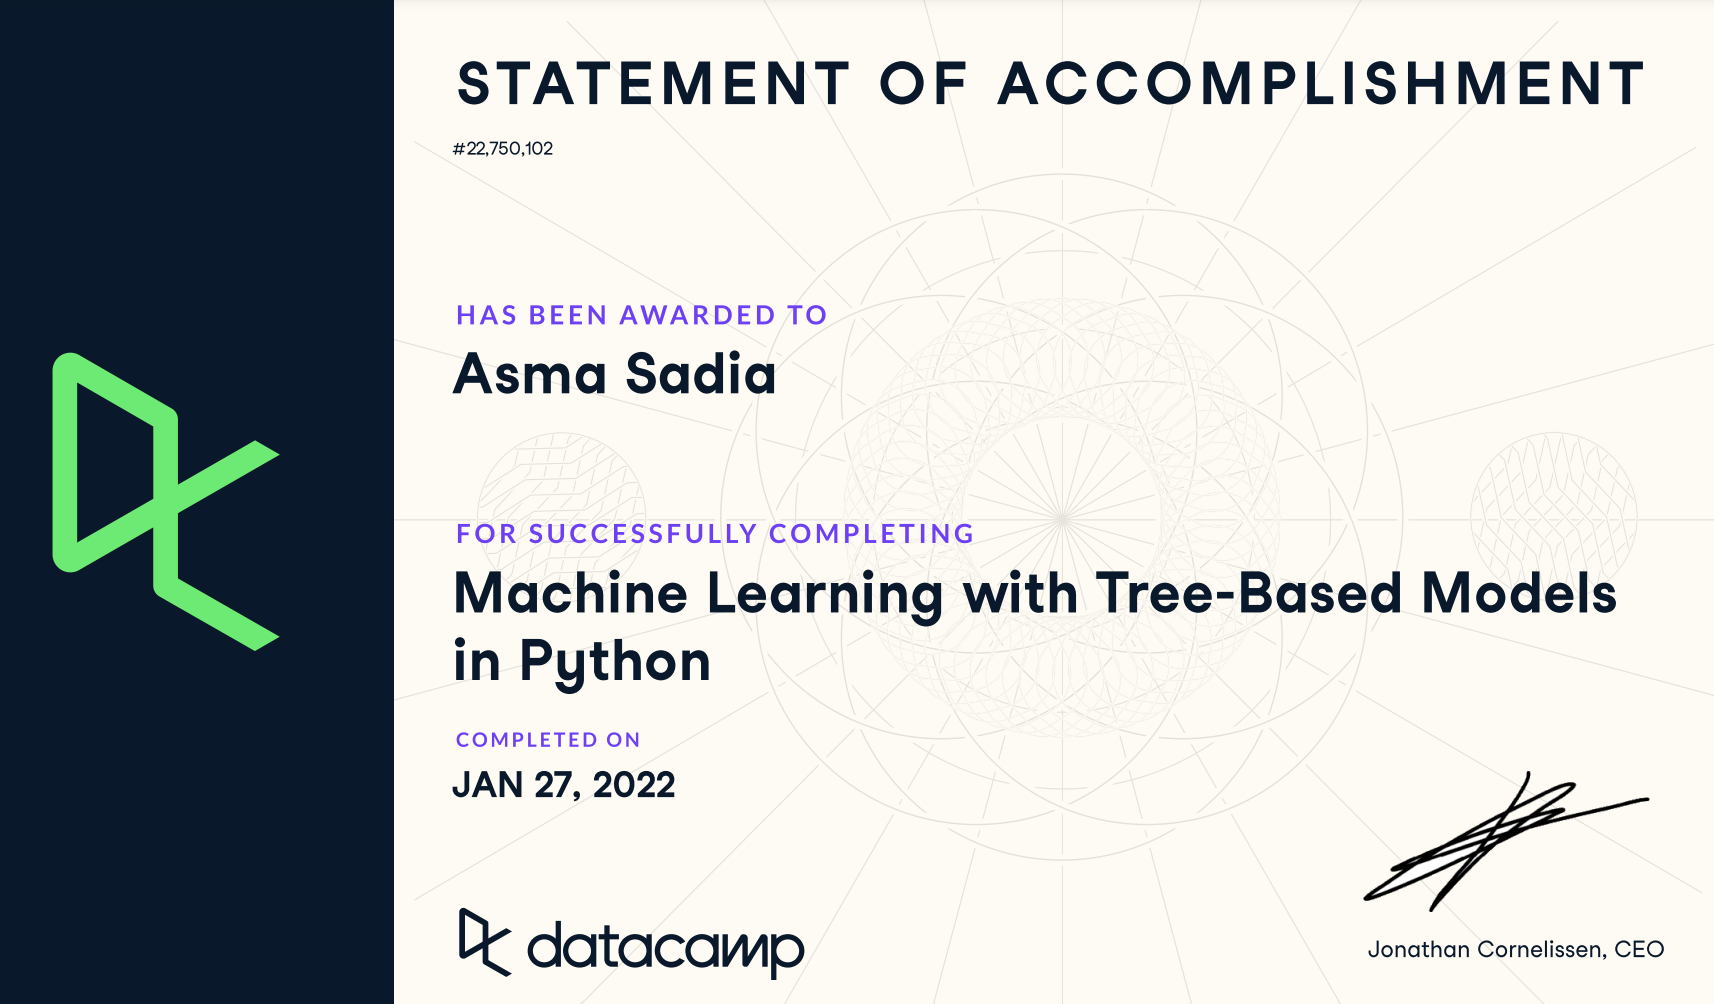